## One Dimension Schrodinger Equation
### Finite Difference Method
https://physics.stackexchange.com/questions/258418/representing-hamiltonian-in-discrete-position-basis

For an arbitrary potential well,the Hamiltonian can be written as 
$$
H = - \frac{\hbar^{2}}{2m} \frac{\partial^{2}}{\partial x^{2}} + V(x) ,-\frac{L}{2}<x<\frac{L}{2}
$$ 
To find the solution $\psi_n(x)$ which satisfies $H \psi_n(x)=E_n \psi_n(x)$,where $n$ stands for the order of the eigenstate,we need to discretize the position basis.
By utilizing the difference form of 
$$
\frac{\partial^{2}\psi}{\partial x^{2}} \approx \frac{[\psi(x+h)-\psi(x)]-[\psi(x)-\psi(x-h)]}{h*h} = \frac{\psi(x+h)+\psi(x-h)-2\psi(x)}{h^{2}}
$$
Write $\psi_n(mh)$ as $\psi_{nm}$ and we can express the Hamiltonian in matrix form
$$
H_{nm} = -\frac{h^{2}}{2m}D_{nm} + V_{nm} 
$$
$$
D=\frac{1}{h^{2}}
\begin{pmatrix}
   -2&1&0&0&\cdots&0\\
   1&-2&1&0&\cdots&0\\
   0&1&-2&1&\cdots&0\\
   \vdots\\
   0&0&0&\cdots&1&-2\\
\end{pmatrix},\quad
V=\begin{pmatrix}
   V(0)&0&0&\cdots&0\\
   0&V(h)&0&\cdots&0\\
   0&0&V(2h)&\cdots&0\\
   \vdots&&&&0\\
   0&0&0&\cdots&V(Nh)\\
\end{pmatrix}
$$
Then the eigenvalue equation $H\psi_n=E_n\psi_n$ can be converted to $H_{nm}\psi_{nm}=E_n \psi_{nm}$,which can be solved by calculating the eigenvalues and eigenvectors

In [97]:
"""
    https://github.com/wangleiphy/UCAS_QMteaching/blob/master/FD_1DSchrodinger.py
"""
import numpy as np 
from scipy.linalg import eigh

#we set mu = hbar = 1

#mesh of the finite difference 
xmin = -1.5; xmax = 1.5; Nmesh = 2000
xmesh = np.linspace(xmin, xmax, Nmesh)
h = xmesh[1] - xmesh[0]

L = 1.0 # potential width 
V = 8.0 # potential depth 
def Vpot(x):
    if abs(x)< L/2.:
        return 3*x**4+0.5*x**3-3*x**2
    else:
        return 0.

According to the analysis, the finite difference Hamiltonian is

In [98]:
def buildH():
    Vx = np.array([Vpot(x) for x in xmesh]) # discretize potential function
    H = np.diag(Vx) 

    for i in range(Nmesh):
        H[i, i] += 1./(h*h)

    for i in range(Nmesh-1):
        H[i, i+1] += -0.5/(h*h)
        H[i+1, i] += -0.5/(h*h)
    # using diag
    
    return H 


Then we can solve the eigenvector and eigenvalue of the matrix $H$ 

energies: [0.42564627 2.11821573]


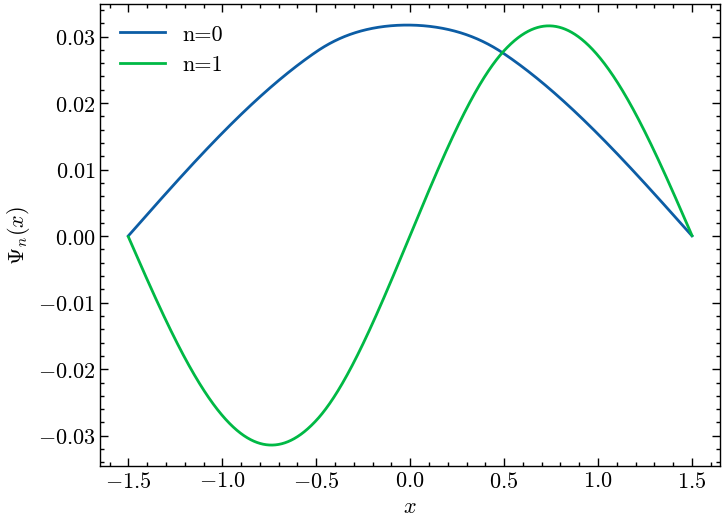

In [99]:
if __name__=='__main__':

    H = buildH()
    w, v = eigh(H) # w eighvalue, v eighvector
    norm = np.linalg.norm(v)
    
    nlowest = 2
    print ('energies:', w[0:nlowest])

    import matplotlib.pyplot as plt
    #plt.plot(xmesh, [Vpot(x) for x in xmesh], 'k-', lw=2)

    for n in range(nlowest):
        plt.plot(xmesh, v[:,n], label='n=%g'%(n), lw=2)
    plt.xlabel(r'$x$')
    plt.ylabel(r'$\Psi_{n}(x)$')
    plt.legend()
    plt.show()

### A JAX Version
JAX.numpy is similar to numpy, but more powerful

In [100]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import scienceplots

plt.style.use(['science', 'notebook', 'no-latex'])

define a class to solve this problem, we can obtain $E_n,\psi_n(x),\rho_n(x),V(x)$, with reference to 华中师范大学《数值分析与计算物理》{https://gitee.com/lgpang/mclphysics_notebooks}

In [101]:
class Potential:
    def __init__(self, potential_func, 
                 mass = 1, hbar = 1,
                 xmin = -5, xmax = 5, ninterval = 1000):
        self.x = jnp.linspace(xmin, xmax, ninterval)
        self.U = jnp.diag(potential_func(self.x), 0)
        self.H = self.U - self.lap(ninterval) * ( hbar**2)/(2*mass)
        self.eigenval, self.eigenvec = self.eigensolve()
    
    def lap(self, N):
        """generate the second derivation matrix"""
        dx = self.x[1] - self.x[0]
        return (-2 * jnp.diag(jnp.ones(N, jnp.float32), 0) + jnp.diag(jnp.ones(N - 1, jnp.float32), 1) + jnp.diag(jnp.ones(N - 1, jnp.float32), -1))/(dx**2)   # here we use jnp.diag
    
    def eigensolve(self):
        """solve the eigenvalue and eigenvector of matrix H"""
        w, v = jnp.linalg.eigh(self.H)
        idx_sorted = jnp.argsort(w)
        return w[idx_sorted], v[:, idx_sorted]

    def energy_level(self, n = 7):
        return self.eigenval[n]
    
    def wave_func(self, n = 7):
        return self.normalize_psi(self.eigenvec[:, n])
    
    def plot_func(self, n = 7):
        """plot the wave function"""
        leg = r'$E_{%s}=%.2f$'%(n, self.eigenval[n])
        plt.plot(self.x, self.wave_func(n), label = leg)
        plt.xlabel(r"$x$")
        plt.ylabel(r'$\psi_{%s}(x)$'%(n))
        plt.legend(loc='best')
    
    def plot_density(self, n = 7):
        """plot the density distribution"""
        rho = self.wave_func(n) * self.wave_func(n)
        leg = r'$E_{%s}=%.2f$'%(n, self.eigenval[n])
        plt.plot(self.x, rho, label = leg)
        plt.xlabel(r"$x$")
        plt.ylabel(r'$\rho_{%s}(x)$'%(n))
        plt.legend(loc='best')
        
    def check(self,n = 1):
        """check H|psi> = E_n|psi>"""
        hpsi = jnp.dot(self.H, self.eigenvec[:, n])
        epsi = self.eigenval[n] * self.eigenvec[:, n]
        plt.plot(self.x, hpsi, label = r'$H|\psi_{%s}\rangle$'%n)
        plt.plot(self.x, epsi, label = r'$E_{%s}|\psi_{%s}\rangle$'%(n,n))
        plt.xlabel(r'$x$')
        plt.legend(loc='best')
        
    def plt_potential(self):
        """plot the potential functial"""
        plt.plot(self.x, jnp.diag(self.U))
        plt.ylabel(r'potential')
        plt.xlabel(r'$x$')
    
    def plot_energy_levels(self, levels=10):
        for n in range(levels):
            plt.plot(self.x, jnp.ones_like(self.x) * self.eigenval[n], label = r'$E_{%s}=%.2f$'%(n, self.eigenval[n]))
        plt.legend()
        plt.ylabel(r'energy levels')
        plt.xlabel(r'$x$')
        print(self.eigenval[0:levels])
        
    def normalize_psi(self, psi):
        """Normalize the wave function."""
        dx = self.x[1] - self.x[0]
        int_psi_square = jnp.trapezoid(psi ** 2, dx=dx)
        return psi / jnp.sqrt(int_psi_square)

#### Harmonic potential $V(x) = \frac{1}{2}m \omega^{2}x^{2}$



In [102]:
def harmonic(x,omega = 10):
    return 0.5*omega**2*x**2

In [103]:
harmonic_schro = Potential(harmonic)

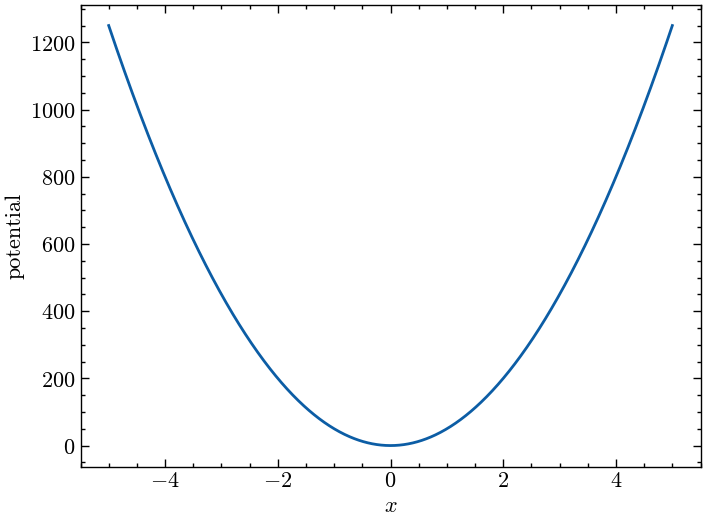

In [104]:
harmonic_schro.plt_potential()

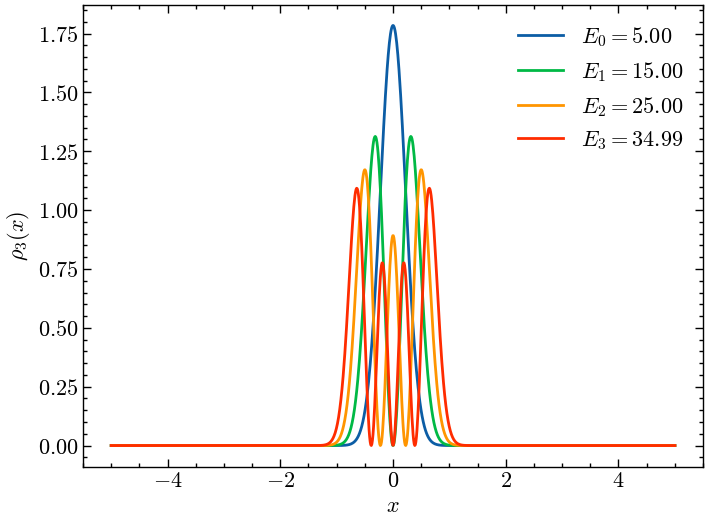

In [105]:
harmonic_schro.plot_density(0)
harmonic_schro.plot_density(1)
harmonic_schro.plot_density(2)
harmonic_schro.plot_density(3)

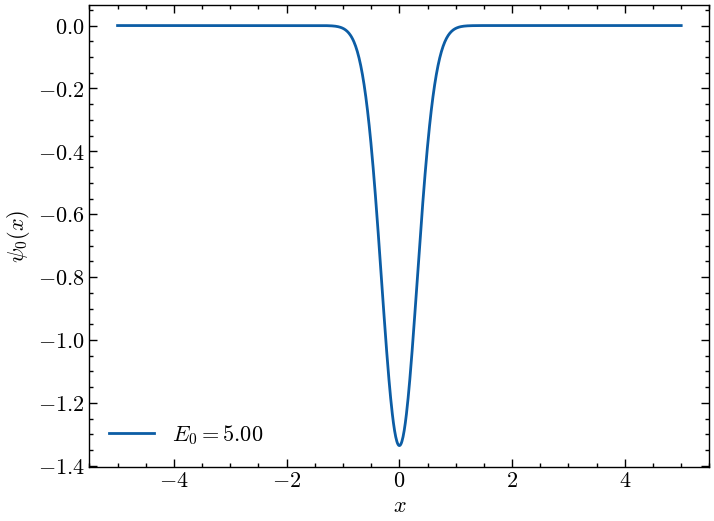

In [106]:
harmonic_schro.plot_func(0)

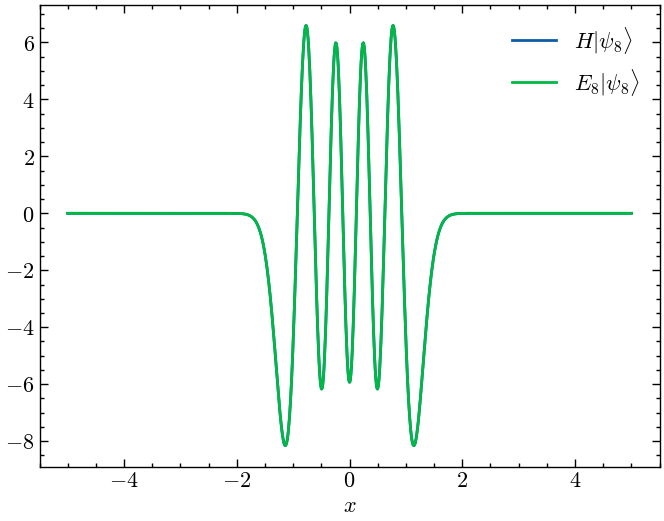

In [107]:
harmonic_schro.check(n=8)

[ 4.999408 14.997921 24.995691 34.99211  44.987762]


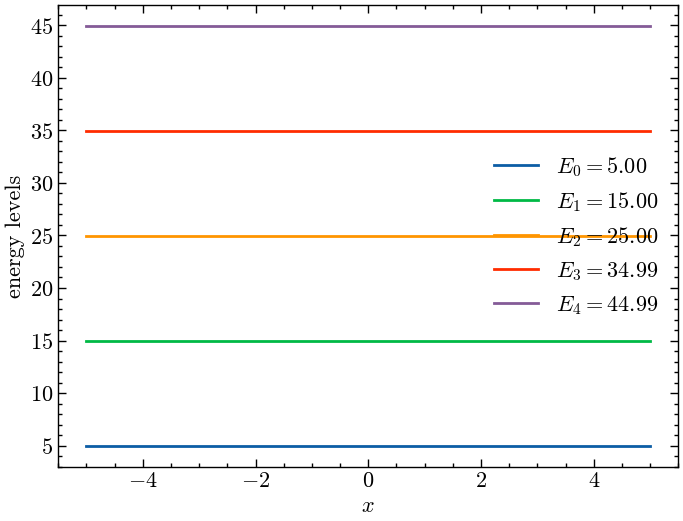

In [108]:
harmonic_schro.plot_energy_levels(levels = 5)

#### infinite square potential well 
$$
V(x) = \begin{cases} 0, & |x| < \frac{a}{2} \\ \infty, & \text{otherwise} \end{cases},E_n = \begin{cases} \frac{(2n+1)^{2}\pi^{2}\hbar^{2}}{2ma^{2}}
, & n = 0,2,4, \ldots  \\\frac{2n^{2}\pi^{2}\hbar^{2}}{ma^{2}} , & n = 1,3,5, \ldots  \end{cases}
$$

In [109]:
def infinite(x, a = 2):
    return 1000 * ((jnp.heaviside(x - a , 0.5) - jnp.heaviside(x + a, 0.5))+1)

In [110]:
inf_schro = Potential(infinite)

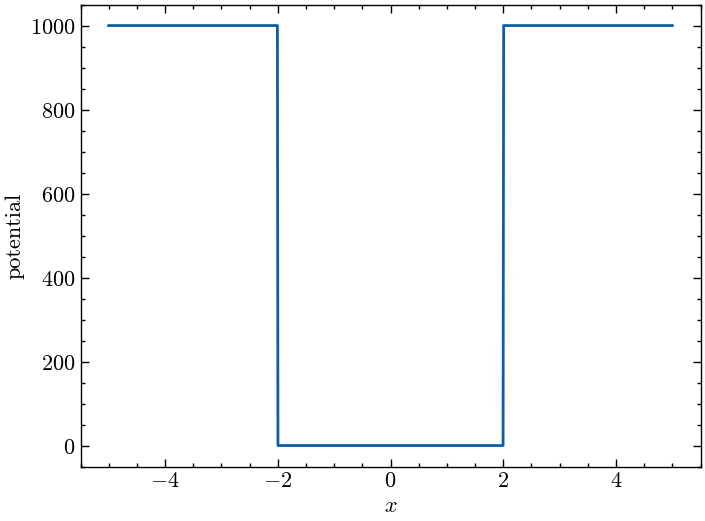

In [111]:
inf_schro.plt_potential()

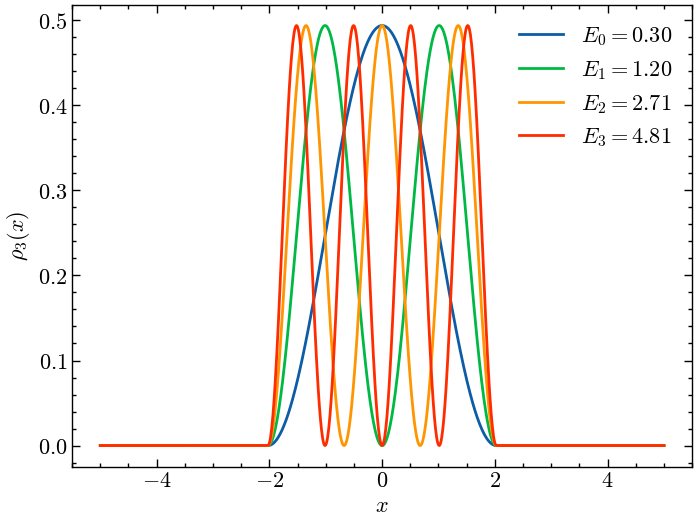

In [112]:
inf_schro.plot_density(0)
inf_schro.plot_density(1)
inf_schro.plot_density(2)
inf_schro.plot_density(3)

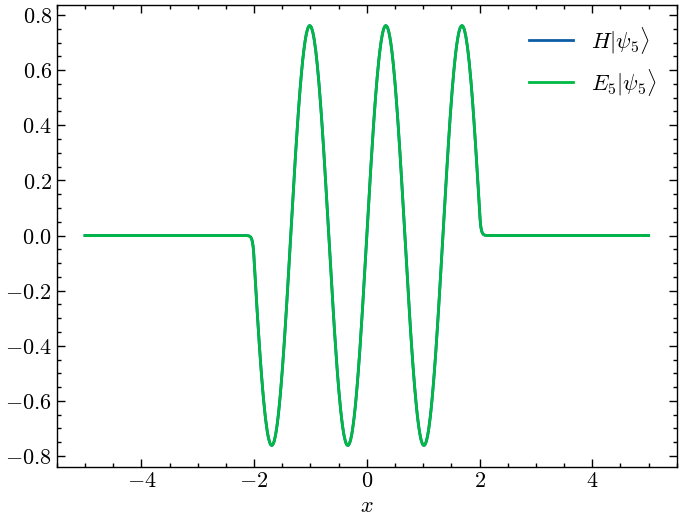

In [113]:
inf_schro.check(5)

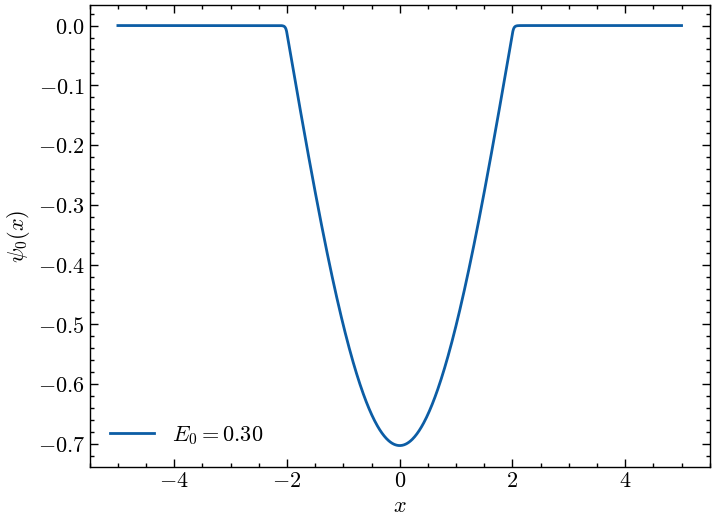

In [114]:
inf_schro.plot_func(0)

[ 0.30002558  1.2026886   2.7070534   4.8130155   7.5204177  10.829072  ]


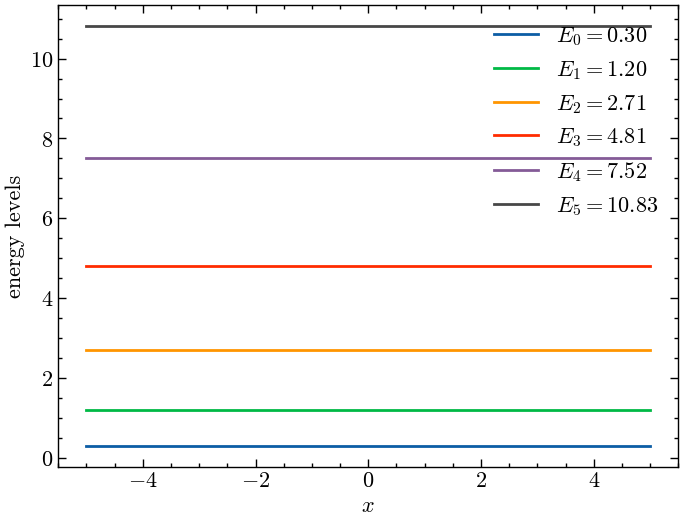

In [115]:
inf_schro.plot_energy_levels(6)

#### arbitrary potential
$$
V(x) = 3x^4+\frac{1}{2}x^3-3x^2
$$

In [116]:
def arb_potential(x):
    return 3*x**4+0.5*x**3-3*x**2

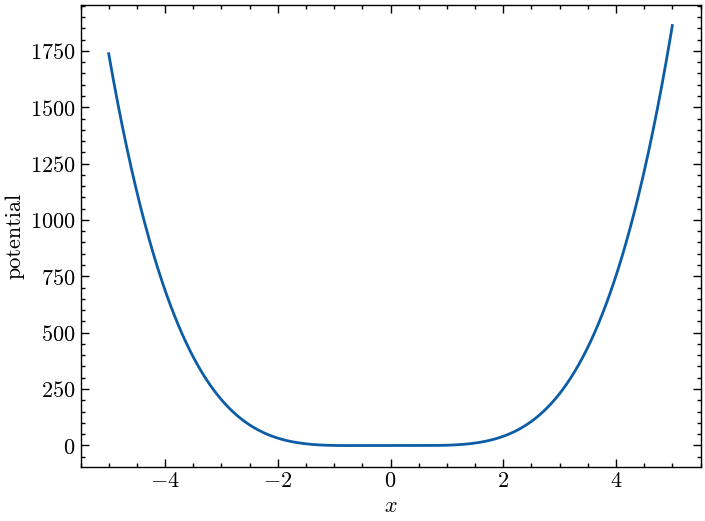

In [117]:
arb_schro = Potential(arb_potential)
arb_schro.plt_potential()

(-1.5, 1.5)

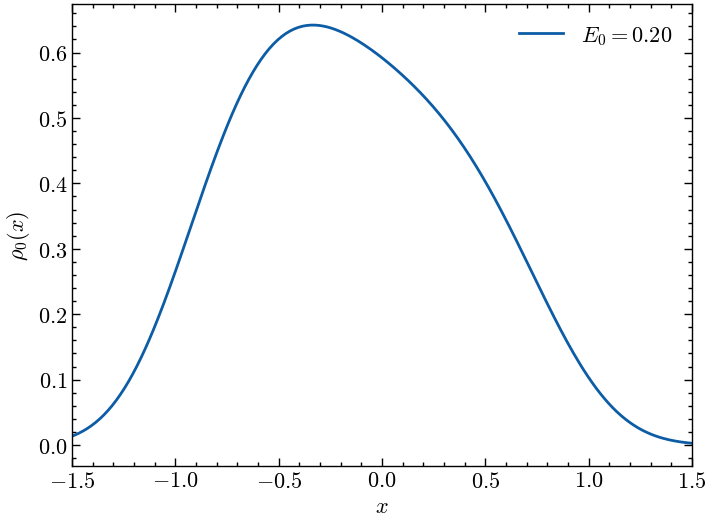

In [118]:
arb_schro.plot_density(0)
plt.xlim(-1.5,1.5)

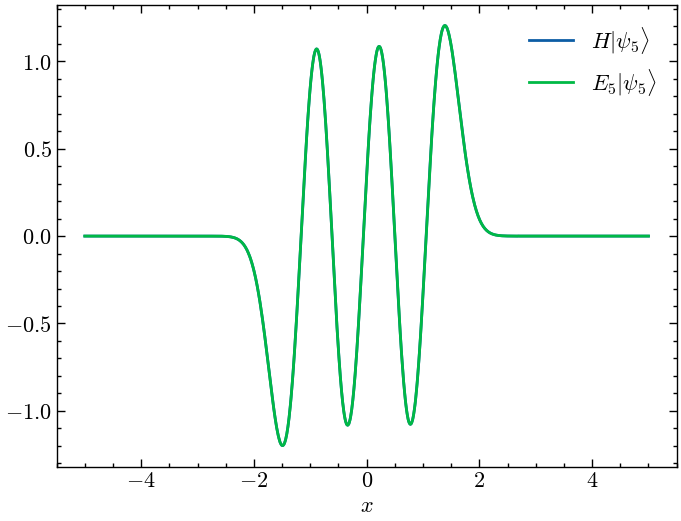

In [119]:
arb_schro.check(5)

[ 0.19513822  1.7360826   4.55034     7.826079   11.548257   15.630089
 20.021702  ]


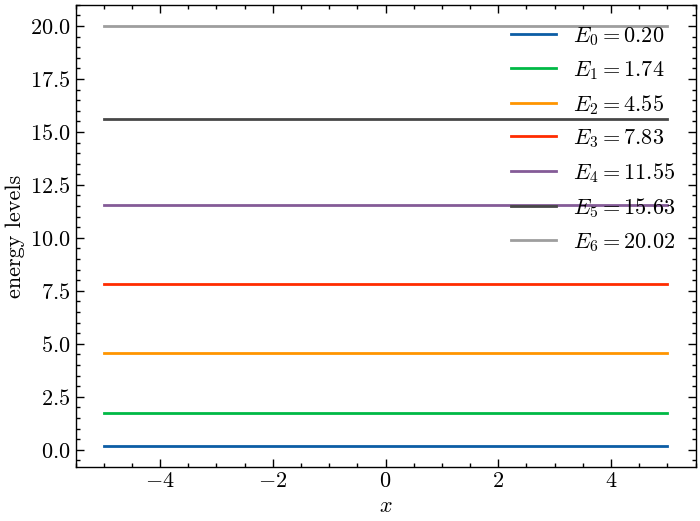

In [120]:
arb_schro.plot_energy_levels(7)

## Variational Method